In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0    
nfreq = 1

In [3]:
# Sx  = 20    
# Sy = 20
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

tpml = 0.4

boundary_layers = [
    mp.PML(tpml, direction=mp.Y),
    mp.PML(tpml, direction=mp.X)
]


tag_bot   = 0.5
tsio2     = 4
tag_side  = 4
design_region_height = 0.5
monitor_position     = 0.5 * 2
monitor_blank        = 0.5 * 0.1

width_ag       = 0.2
width_sio2     = 2
width_bot_ag   = round(width_ag + width_sio2 + width_ag, 2)
design_region_width  = round(width_bot_ag, 3)

Sx = 20
Sy = 20
cell_size   = mp.Vector3(Sx, Sy)

y_bottom = -Sy/2 + tpml
center_y_ag        = y_bottom + tag_bot/2
center_y_sio2      = y_bottom + tag_bot + tsio2/2
center_y_design    = y_bottom + tag_bot + tsio2 + design_region_height/2
center_y_monitor_position   = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position    = y_bottom + tag_bot + 5/fcen  # 예시
center_Ag_x_offset = design_region_width/2 - width_ag/2

Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1

geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side Ag layers
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_offset, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3( center_Ag_x_offset, center_y_sio2, 0)
    ),
]

In [15]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [16]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

In [17]:
r = 20           # 20 μm 떨어진 곳

inner_x = Sx - 2*tpml
inner_y = Sy - 2*tpml
y_off = 0.5 * inner_y - 2/resolution

dft_line = sims[0].add_dft_fields(
    [mp.Ez],        # 측정할 성분
    fcen, 0, 1,     # 중심주파수, 대역폭(df=0), 샘플수=1
    
    center=mp.Vector3(0, y_off, 0),
    size  = mp.Vector3(inner_x, 0, 0)
    
)

     block, center = (0,-9.35,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-7.1,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

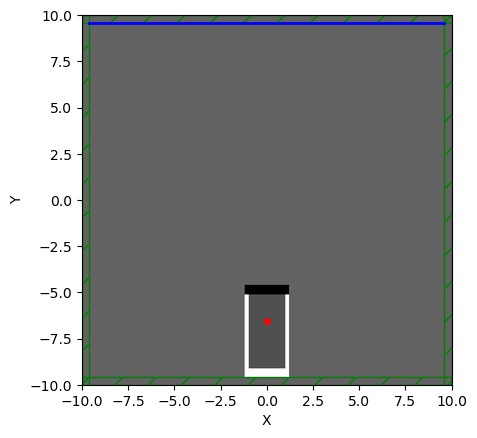

In [18]:
sims[0].plot2D()

In [19]:
sims[0].run(until_after_sources=mp.stop_when_dft_decayed())

# sims[0].run(until=300)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000329971 s
Working in 2D dimensions.
Computational cell is 20 x 20 x 0 with resolution 50
     block, center = (0,-9.35,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-7.1,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0

     block, center = (0,-9.35,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-7.1,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

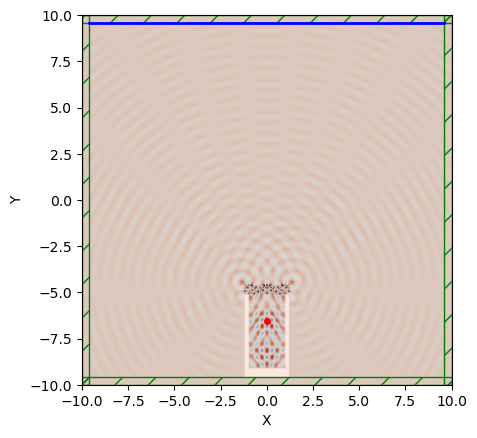

In [20]:
sims[0].plot2D(fields=mp.Ez,)

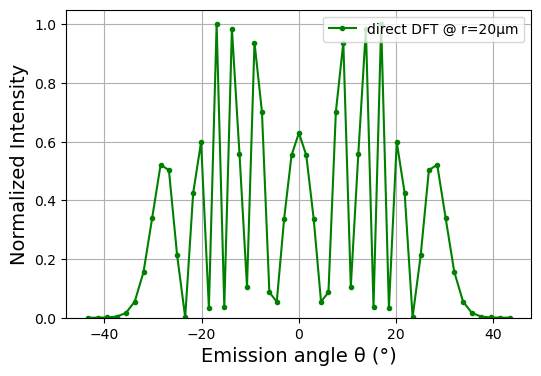

In [22]:
Ez_far = np.real(sims[0].get_dft_array(dft_line, mp.Ez, 0))

# 2) FFT
N       = Ez_far.size
dx      = 1.0 / resolution           # 공간 샘플 간격
E_k     = np.fft.fftshift(np.fft.fft(Ez_far)) / N
kx_cyc  = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
kx      = 2*np.pi * kx_cyc
k0      = 2*np.pi * fcen

# 3) kx → θ 변환
θ_rad   = np.arcsin(np.clip(kx/k0, -1, 1))
θ_deg   = np.degrees(θ_rad)

# 4) 파워 스펙트럼 P(θ)
P_far   = np.abs(E_k)**2 * (k0 * np.cos(θ_rad))

# 5) 원하는 각도 범위만 골라 정규화
mask    = (θ_deg >= -45) & (θ_deg <= +45)
θ_plot  = θ_deg[mask]
P_plot  = P_far[mask]
P_norm  = P_plot / np.max(P_plot)

# 6) 그래프
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(θ_plot, P_norm, 'g.-', label='direct DFT @ r=20μm')
plt.xlabel('Emission angle θ (°)', fontsize=14)
plt.ylabel('Normalized Intensity', fontsize=14)
# plt.xlim(-10,10)
plt.ylim(0,1.05)
plt.legend()
plt.grid(True)
plt.show()